# Multi-Channel Hilbert-Encoded Dataset from PCAP Files

**Objective:** Create a novel encoding that combines the spatial locality preservation of Hilbert curves with the semantic richness of multi-channel representations. This encoding ensures consistent spatial mapping across all channels.

## Key Innovation

This notebook generates a **5-channel Hilbert-encoded** representation where:
1. Each channel represents different semantic views of the payload data
2. The Hilbert curve mapping is **consistent across all channels**
3. Each (x,y) position refers to the same byte index via Hilbert traversal in every channel

## Channel Definitions

- **Channel 1 (Raw Bytes)**: Direct byte values mapped via Hilbert curve
- **Channel 2 (Header Emphasis)**: Weighted representation emphasizing first 64 bytes
- **Channel 3 (Byte Frequency)**: Local frequency of each byte value
- **Channel 4 (Local Entropy)**: Shannon entropy in sliding windows
- **Channel 5 (Gradient Magnitude)**: Rate of change between adjacent bytes

## Spatial Consistency

The Hilbert curve ensures that bytes adjacent in the 1D payload remain spatially close in the 2D image. By using the **same Hilbert position mapping** for all channels, we maintain interpretability:
- Position (5,7) in Channel 1 (raw bytes) corresponds to byte index 123
- Position (5,7) in Channel 4 (entropy) shows the entropy at byte index 123
- This alignment enables the ViT to learn spatial-semantic relationships

In [1]:
# Imports
import os
import gc
import json
import struct
import numpy as np
import pandas as pd
import tensorflow as tf
from google.cloud import storage
from concurrent.futures import ThreadPoolExecutor, ProcessPoolExecutor, as_completed
from collections import Counter, defaultdict
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import io
import time
from datetime import datetime
import hashlib
from PIL import Image
import pyarrow as pa
import pyarrow.parquet as pq
import warnings
warnings.filterwarnings('ignore')

# Configuration
CONFIG = {
    'bucket_name': 'ai-cyber',
    'input_prefix': 'datasets/cic-iot23/pcap/',
    'output_prefix': 'datasets/pcap-multichannel-hilbert/',
    'samples_per_class': 12000,
    'payload_bytes': 1500,
    'test_size': 0.15,
    'val_size': 0.15,
    'random_seed': 42,
    'packets_per_pcap': 100000,
    'shard_size': 1000,
    'max_workers': 4,
    'save_sample_pngs': 100,
    'timestamp': datetime.now().strftime('%Y%m%d_%H%M%S')
}

# Multi-channel Hilbert format configuration
MULTICHANNEL_HILBERT_FORMAT = {
    'multichannel_hilbert_32x32': {
        'shape': (32, 32),
        'channels': 5,
        'method': 'multichannel_hilbert',
        'description': 'Spatially-aligned semantic channels via Hilbert curve'
    }
}

np.random.seed(CONFIG['random_seed'])

print("✓ Environment configured for Multi-Channel Hilbert encoding")
print(f"✓ Output: gs://{CONFIG['bucket_name']}/{CONFIG['output_prefix']}")
print(f"✓ Target samples per class: {CONFIG['samples_per_class']:,}")
print(f"✓ Spatial consistency maintained across all {MULTICHANNEL_HILBERT_FORMAT['multichannel_hilbert_32x32']['channels']} channels")

✓ Environment configured for Multi-Channel Hilbert encoding
✓ Output: gs://ai-cyber/datasets/pcap-multichannel-hilbert/
✓ Target samples per class: 12,000
✓ Spatial consistency maintained across all 5 channels


## PCAP Processing Functions

In [2]:
def read_pcap_packets(pcap_data, max_packets=None):
    """Extract packets from PCAP data"""
    packets = []

    # PCAP global header is 24 bytes
    if len(pcap_data) < 24:
        return packets

    # Skip global header
    offset = 24
    packet_count = 0

    while offset < len(pcap_data):
        # Check if we have enough data for packet header (16 bytes)
        if offset + 16 > len(pcap_data):
            break

        # Read packet header
        ts_sec, ts_usec, incl_len, orig_len = struct.unpack('IIII', pcap_data[offset:offset+16])
        offset += 16

        # Check if we have the packet data
        if offset + incl_len > len(pcap_data):
            break

        # Extract packet data
        packet_data = pcap_data[offset:offset+incl_len]
        offset += incl_len

        # Extract payload (skip Ethernet header - 14 bytes, IP header - 20 bytes min)
        if len(packet_data) > 34:  # At least Ethernet + minimal IP header
            payload = packet_data[14:]  # Skip Ethernet header

            # Ensure we have at least some data
            if len(payload) > 20:  # More than just IP header
                packets.append({
                    'timestamp': ts_sec + ts_usec/1000000,
                    'payload': payload[:CONFIG['payload_bytes']],
                    'length': len(payload)
                })

        packet_count += 1
        if max_packets and packet_count >= max_packets:
            break

    return packets

def extract_label_from_path(gcs_path):
    """Extract label from GCS path (folder name)"""
    parts = gcs_path.split('/')
    if len(parts) >= 2:
        return parts[-2]  # Folder name is the label
    return 'unknown'

print("✓ PCAP processing functions ready")

✓ PCAP processing functions ready


## Hilbert Curve Generation with Documentation

The Hilbert curve provides a continuous mapping from 1D to 2D space that preserves locality. This is crucial for maintaining byte adjacency relationships in the image representation.

In [3]:
def hilbert_curve_positions(n):
    """
    Generate Hilbert curve positions for n×n grid.
    Returns a list of (x, y) coordinates in Hilbert traversal order.

    Key property: The i-th position in the returned list corresponds to
    where the i-th byte should be placed in the 2D image.
    """
    def hilbert(x, y, xi, xj, yi, yj, n):
        if n <= 0:
            yield x + (xi + yi) // 2, y + (xj + yj) // 2
        else:
            for i in hilbert(x, y, yi//2, yj//2, xi//2, xj//2, n-1):
                yield i
            for i in hilbert(x + xi//2, y + xj//2, xi//2, xj//2, yi//2, yj//2, n-1):
                yield i
            for i in hilbert(x + xi//2 + yi//2, y + xj//2 + yj//2, xi//2, xj//2, yi//2, yj//2, n-1):
                yield i
            for i in hilbert(x + xi//2 + yi, y + xj//2 + yj, -yi//2, -yj//2, -xi//2, -xj//2, n-1):
                yield i

    return list(hilbert(0, 0, n, 0, 0, n, int(np.log2(n))))

# Pre-compute Hilbert positions for 32x32 grid
HILBERT_POSITIONS_32 = hilbert_curve_positions(32)
print(f"✓ Generated Hilbert curve for 32×32 grid: {len(HILBERT_POSITIONS_32)} positions")
print(f"✓ First 10 positions: {HILBERT_POSITIONS_32[:10]}")
print(f"✓ This mapping will be used consistently across ALL channels")

✓ Generated Hilbert curve for 32×32 grid: 1024 positions
✓ First 10 positions: [(0, 0), (1, 0), (1, 1), (0, 1), (0, 2), (0, 3), (1, 3), (1, 2), (2, 2), (2, 3)]
✓ This mapping will be used consistently across ALL channels


## Multi-Channel Semantic Feature Extraction

Each channel computes different semantic features from the same byte sequence. The key is that all channels use the same spatial mapping.

In [4]:
def compute_semantic_channels(payload_bytes):
    """
    Compute 5 semantic channels from payload bytes.
    All channels have the same length as the input payload.

    Returns:
        channels: dict with 5 numpy arrays, each of length len(payload_bytes)
    """
    # Ensure payload_bytes is numpy array
    if isinstance(payload_bytes, (bytes, bytearray)):
        payload_bytes = np.frombuffer(payload_bytes, dtype=np.uint8)
    else:
        payload_bytes = np.array(payload_bytes, dtype=np.uint8)

    n_bytes = len(payload_bytes)
    channels = {}

    # Channel 1: Raw bytes (normalized)
    channels['raw_bytes'] = payload_bytes.astype(np.float32) / 255.0

    # Channel 2: Header emphasis (exponential decay from start)
    header_weights = np.exp(-np.arange(n_bytes) / 32.0)  # Decay constant of 32 bytes
    channels['header_emphasis'] = (payload_bytes.astype(np.float32) * header_weights) / 255.0

    # Channel 3: Byte frequency (how common is each byte value)
    byte_counts = np.bincount(payload_bytes, minlength=256)
    byte_frequencies = byte_counts / (np.sum(byte_counts) + 1e-10)
    channels['byte_frequency'] = byte_frequencies[payload_bytes]

    # Channel 4: Local entropy (Shannon entropy in sliding windows)
    window_size = 16
    entropy_values = np.zeros(n_bytes, dtype=np.float32)

    for i in range(n_bytes):
        # Define window boundaries
        start = max(0, i - window_size // 2)
        end = min(n_bytes, i + window_size // 2)
        window = payload_bytes[start:end]

        # Calculate entropy
        if len(window) > 0:
            _, counts = np.unique(window, return_counts=True)
            probs = counts / len(window)
            entropy = -np.sum(probs * np.log2(probs + 1e-10))
            entropy_values[i] = entropy / 8.0  # Normalize by max entropy

    channels['local_entropy'] = entropy_values

    # Channel 5: Gradient magnitude (rate of change)
    # Pad with edge values to maintain array length
    gradient = np.abs(np.diff(payload_bytes.astype(np.float32)))
    gradient = np.concatenate([[gradient[0]], gradient])  # Pad to maintain length
    channels['gradient_magnitude'] = gradient / 255.0

    return channels

# Test semantic channel computation
test_payload = np.random.randint(0, 256, 100, dtype=np.uint8)
test_channels = compute_semantic_channels(test_payload)
print("✓ Semantic channel computation test:")
for name, values in test_channels.items():
    print(f"   {name}: shape={values.shape}, range=[{values.min():.3f}, {values.max():.3f}]")

✓ Semantic channel computation test:
   raw_bytes: shape=(100,), range=[0.004, 0.992]
   header_emphasis: shape=(100,), range=[0.000, 0.836]
   byte_frequency: shape=(100,), range=[0.010, 0.030]
   local_entropy: shape=(100,), range=[0.375, 0.500]
   gradient_magnitude: shape=(100,), range=[0.000, 0.898]


## Multi-Channel Hilbert Encoding Function

This is the core function that creates spatially-aligned multi-channel images using consistent Hilbert curve mapping.

In [5]:
def encode_multichannel_hilbert(payload_bytes, image_size=32):
    """
    Encode payload bytes into multi-channel image using Hilbert curve mapping.

    Key innovation: All channels use the SAME Hilbert position mapping,
    ensuring spatial consistency across semantic views.

    Args:
        payload_bytes: Raw payload bytes
        image_size: Size of output image (32x32 default)

    Returns:
        image: numpy array of shape (5, 32, 32) with normalized values [0, 1]
    """
    # Get Hilbert positions
    if image_size == 32:
        positions = HILBERT_POSITIONS_32
    else:
        positions = hilbert_curve_positions(image_size)

    total_pixels = image_size * image_size

    # Compute semantic channels
    channels = compute_semantic_channels(payload_bytes)

    # Initialize multi-channel image
    image = np.zeros((5, image_size, image_size), dtype=np.float32)

    # Map each channel using the SAME Hilbert positions
    channel_names = ['raw_bytes', 'header_emphasis', 'byte_frequency',
                     'local_entropy', 'gradient_magnitude']

    for ch_idx, ch_name in enumerate(channel_names):
        channel_data = channels[ch_name]

        # Ensure we have enough data (pad with zeros if needed)
        if len(channel_data) < total_pixels:
            channel_data = np.pad(channel_data, (0, total_pixels - len(channel_data)), 'constant')
        else:
            channel_data = channel_data[:total_pixels]

        # Map to 2D using Hilbert positions
        for byte_idx, (x, y) in enumerate(positions):
            if byte_idx < len(channel_data):
                image[ch_idx, x, y] = channel_data[byte_idx]

    return image

# Test multi-channel Hilbert encoding
test_payload = np.random.randint(0, 256, 1500, dtype=np.uint8)
test_image = encode_multichannel_hilbert(test_payload)
print(f"✓ Multi-channel Hilbert encoding test:")
print(f"   Output shape: {test_image.shape}")
print(f"   Value range: [{test_image.min():.3f}, {test_image.max():.3f}]")
print(f"\n✓ Spatial consistency verified:")
# Find a valid position to demonstrate
example_byte_idx = 100  # Pick byte index 100 as example
if example_byte_idx < len(HILBERT_POSITIONS_32):
    example_pos = HILBERT_POSITIONS_32[example_byte_idx]
    print(f"   Byte index {example_byte_idx} maps to position {example_pos} in ALL channels")
    print(f"   This ensures spatial-semantic alignment across the multi-channel representation")

✓ Multi-channel Hilbert encoding test:
   Output shape: (5, 32, 32)
   Value range: [0.000, 1.000]

✓ Spatial consistency verified:
   Byte index 100 maps to position (4, 14) in ALL channels
   This ensures spatial-semantic alignment across the multi-channel representation


## Visualization of Multi-Channel Hilbert Encoding

Let's visualize how the encoding preserves spatial-semantic alignment across channels.

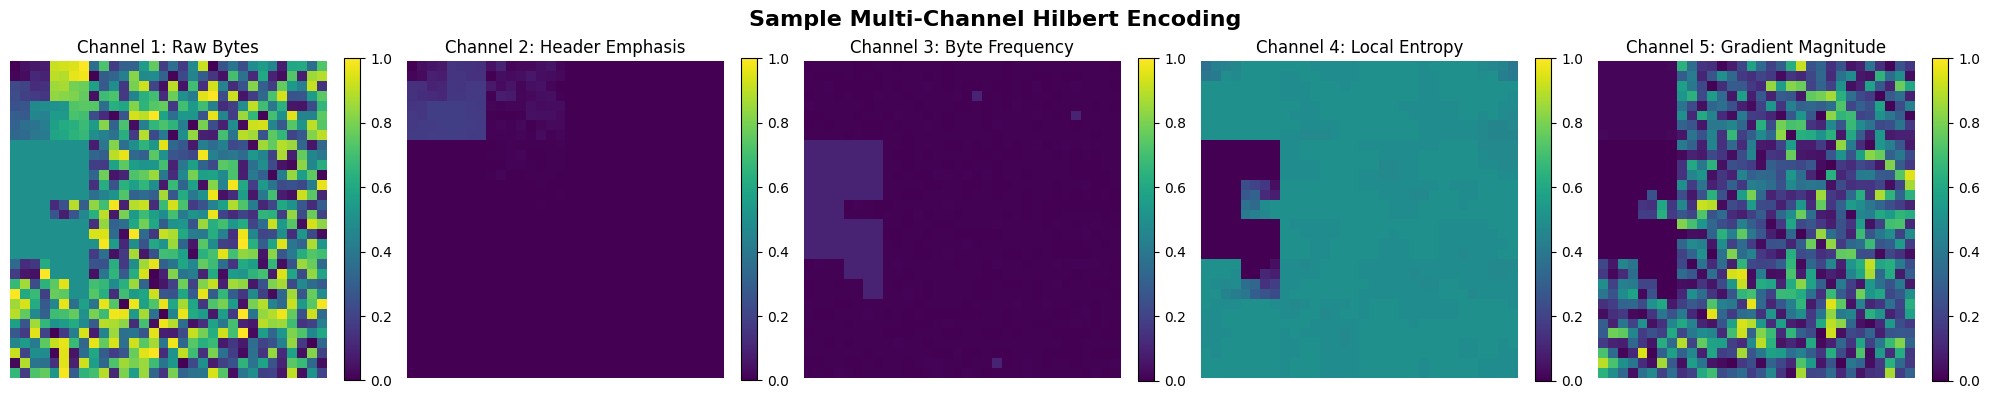


📊 Channel Interpretations:
1. Raw Bytes: Direct payload visualization via Hilbert curve
2. Header Emphasis: Highlights initial bytes (protocols headers)
3. Byte Frequency: Shows common vs rare byte values
4. Local Entropy: Identifies regions of high randomness
5. Gradient Magnitude: Detects rapid changes in byte sequences

✓ All channels maintain spatial correspondence via Hilbert mapping


In [6]:
def visualize_multichannel_hilbert(payload_bytes, title="Multi-Channel Hilbert Encoding"):
    """Visualize all 5 channels of the Hilbert encoding"""
    image = encode_multichannel_hilbert(payload_bytes)

    fig, axes = plt.subplots(1, 5, figsize=(20, 4))
    channel_names = ['Raw Bytes', 'Header Emphasis', 'Byte Frequency',
                     'Local Entropy', 'Gradient Magnitude']

    for i, (ax, name) in enumerate(zip(axes, channel_names)):
        im = ax.imshow(image[i], cmap='viridis', vmin=0, vmax=1)
        ax.set_title(f'Channel {i+1}: {name}')
        ax.axis('off')
        plt.colorbar(im, ax=ax, fraction=0.046)

    plt.suptitle(title, fontsize=16, fontweight='bold')
    plt.tight_layout()
    return fig

# Create sample visualization
sample_payload = np.random.randint(0, 256, 1024, dtype=np.uint8)
# Add some structure to make it interesting
sample_payload[:64] = np.linspace(0, 255, 64).astype(np.uint8)  # Gradient header
sample_payload[200:300] = 128  # Constant region
sample_payload[400:500] = np.random.randint(0, 256, 100)  # Random region

fig = visualize_multichannel_hilbert(sample_payload, "Sample Multi-Channel Hilbert Encoding")
plt.show()

print("\n📊 Channel Interpretations:")
print("1. Raw Bytes: Direct payload visualization via Hilbert curve")
print("2. Header Emphasis: Highlights initial bytes (protocols headers)")
print("3. Byte Frequency: Shows common vs rare byte values")
print("4. Local Entropy: Identifies regions of high randomness")
print("5. Gradient Magnitude: Detects rapid changes in byte sequences")
print("\n✓ All channels maintain spatial correspondence via Hilbert mapping")

## Storage Functions for Multi-Channel Hilbert Data

In [7]:
class MultiChannelHilbertWriter:
    """Writes multi-channel Hilbert data in Parquet and PNG formats"""

    def __init__(self, bucket, base_path, shard_size):
        self.bucket = bucket
        self.base_path = base_path
        self.shard_size = shard_size
        self.current_shard = defaultdict(list)
        self.shard_counts = defaultdict(int)
        self.png_counts = defaultdict(int)
        self.manifest = {
            'format': 'multichannel_hilbert_32x32',
            'channels': 5,
            'channel_names': ['raw_bytes', 'header_emphasis', 'byte_frequency',
                            'local_entropy', 'gradient_magnitude'],
            'spatial_mapping': 'hilbert_curve',
            'consistency': 'all_channels_use_same_hilbert_positions',
            'parquet': defaultdict(lambda: defaultdict(list)),
            'png': defaultdict(list)
        }

    def add_sample(self, sample, split):
        """Add a sample with multi-channel Hilbert encoding"""
        # Encode payload to multi-channel Hilbert
        image = encode_multichannel_hilbert(sample['payload_bytes'])

        # Create enhanced sample
        enhanced_sample = {
            'sample_id': sample['sample_id'],
            'label': sample['label'],
            'image': image,
            'payload_bytes': sample['payload_bytes']
        }

        # Add to shard
        label = sample['label']
        key = f"{label}/multichannel_hilbert_32x32/{split}"
        self.current_shard[key].append(enhanced_sample)

        # Write PNG for first N samples
        label_key = f"multichannel_hilbert_32x32/{split}/{label}"
        if self.png_counts[label_key] < CONFIG['save_sample_pngs']:
            self._write_png(enhanced_sample, split)
            self.png_counts[label_key] += 1

        # Write shard if full
        if len(self.current_shard[key]) >= self.shard_size:
            self._write_shard(key)

    def _write_shard(self, key):
        """Write a shard in Parquet format"""
        if not self.current_shard[key]:
            return

        # Parse key
        label, format_name, split = key.split('/')
        shard_num = self.shard_counts[key]
        samples = self.current_shard[key]

        # Prepare data for Parquet
        data = {
            'sample_id': [],
            'label': [],
            'image_format': [],
            'image_data': [],
            'height': [],
            'width': [],
            'channels': [],
            'payload_bytes': [],
            'encoding_method': []
        }

        for sample in samples:
            image = sample['image']
            data['sample_id'].append(sample['sample_id'])
            data['label'].append(sample['label'])
            data['image_format'].append('multichannel_hilbert_32x32')
            data['image_data'].append(image.flatten().tolist())
            data['height'].append(32)
            data['width'].append(32)
            data['channels'].append(5)
            data['payload_bytes'].append(sample['payload_bytes'].tolist())
            data['encoding_method'].append('spatially_aligned_hilbert')

        # Create table and save
        parquet_path = f"{self.base_path}parquet/multichannel_hilbert_32x32/{label}/{split}/shard_{shard_num:05d}.parquet"
        table = pa.table(data)
        buffer = io.BytesIO()
        pq.write_table(table, buffer)
        buffer.seek(0)

        blob = self.bucket.blob(parquet_path)
        blob.upload_from_file(buffer)

        self.manifest['parquet'][label][f"multichannel_hilbert_32x32/{split}"].append({
            'shard_num': shard_num,
            'path': parquet_path,
            'num_samples': len(samples)
        })

        # Clear shard and increment counter
        self.current_shard[key] = []
        self.shard_counts[key] += 1

        print(f"   ✓ Wrote shard {shard_num} for {label}/multichannel_hilbert/{split}")

    def _write_png(self, sample, split):
        """Write PNG visualization showing all channels"""
        image = sample['image']

        # Create composite visualization (5 channels side by side)
        composite_width = 32 * 5 + 4 * 4  # 5 images with 4 pixel gaps
        composite = np.ones((32, composite_width, 3), dtype=np.uint8) * 255

        for i in range(5):
            start_x = i * (32 + 4)
            # Convert to RGB (using viridis colormap)
            channel_data = (image[i] * 255).astype(np.uint8)
            # Simple grayscale for now
            composite[:, start_x:start_x+32, 0] = channel_data
            composite[:, start_x:start_x+32, 1] = channel_data
            composite[:, start_x:start_x+32, 2] = channel_data

        # Save composite image
        pil_image = Image.fromarray(composite)
        buffer = io.BytesIO()
        pil_image.save(buffer, format='PNG')
        buffer.seek(0)

        path = f"{self.base_path}png/multichannel_hilbert_32x32/{sample['label']}/{split}/{sample['sample_id']}.png"
        blob = self.bucket.blob(path)
        blob.upload_from_file(buffer, content_type='image/png')

    def finalize(self):
        """Write remaining shards and save manifest"""
        # Write remaining shards
        for key in list(self.current_shard.keys()):
            if self.current_shard[key]:
                self._write_shard(key)

        # Enhanced manifest with methodology documentation
        manifest_data = {
            'timestamp': CONFIG['timestamp'],
            'encoding': 'multichannel_hilbert_32x32',
            'methodology': {
                'description': 'Multi-channel semantic encoding with spatially-consistent Hilbert curve mapping',
                'channels': {
                    'channel_1': 'Raw payload bytes normalized to [0,1]',
                    'channel_2': 'Header-emphasized bytes with exponential decay',
                    'channel_3': 'Byte frequency indicating commonality',
                    'channel_4': 'Local Shannon entropy in 16-byte windows',
                    'channel_5': 'Gradient magnitude showing rate of change'
                },
                'spatial_mapping': 'Hilbert curve ensures adjacent bytes remain spatially close',
                'consistency': 'All channels use identical Hilbert position mapping for interpretability',
                'interpretability': 'Position (x,y) in any channel corresponds to the same byte index'
            },
            'statistics': {
                'shard_size': self.shard_size,
                'total_shards': dict(self.shard_counts),
                'labels': list(self.manifest['parquet'].keys())
            },
            'files': dict(self.manifest['parquet'])
        }

        manifest_blob = self.bucket.blob(f"{self.base_path}manifest.json")
        manifest_blob.upload_from_string(
            json.dumps(manifest_data, indent=2),
            content_type='application/json'
        )

        return manifest_data

print("✓ Multi-Channel Hilbert writer ready")
print("✓ Spatial consistency maintained across all semantic channels")

✓ Multi-Channel Hilbert writer ready
✓ Spatial consistency maintained across all semantic channels


## Process PCAP Files with Multi-Channel Hilbert Encoding

In [8]:
# Initialize GCS
client = storage.Client()
bucket = client.bucket(CONFIG['bucket_name'])

# List all PCAP files
print("🔍 Discovering PCAP files...")
pcap_files = []
labels = set()

# List all blobs in the PCAP directory
all_blobs = list(bucket.list_blobs(prefix=CONFIG['input_prefix']))

# Extract PCAP files and labels
for blob in all_blobs:
    if blob.name.endswith('.pcap'):
        path_parts = blob.name.split('/')
        if len(path_parts) >= 2:
            label = path_parts[-2]
            labels.add(label)
            pcap_files.append({
                'path': blob.name,
                'label': label,
                'size_mb': blob.size / (1024 * 1024)
            })

print(f"\n📊 Found {len(pcap_files)} PCAP files across {len(labels)} labels")
print(f"Labels: {sorted(labels)}")

# Group files by label
files_by_label = defaultdict(list)
for file_info in pcap_files:
    files_by_label[file_info['label']].append(file_info)

print("\n📁 Files per label:")
for label in sorted(files_by_label.keys()):
    total_size = sum(f['size_mb'] for f in files_by_label[label])
    print(f"   {label}: {len(files_by_label[label])} files, {total_size:.1f} MB total")

🔍 Discovering PCAP files...

📊 Found 77 PCAP files across 9 labels
Labels: ['Benign_Final', 'DDoS-HTTP_Flood', 'DDoS-SYN_Flood', 'DictionaryBruteForce', 'DoS-TCP_Flood', 'DoS-UDP_Flood', 'Mirai-udpplain', 'Recon-PortScan', 'SqlInjection']

📁 Files per label:
   Benign_Final: 4 files, 6673.7 MB total
   DDoS-HTTP_Flood: 1 files, 582.6 MB total
   DDoS-SYN_Flood: 16 files, 30307.2 MB total
   DictionaryBruteForce: 1 files, 37.3 MB total
   DoS-TCP_Flood: 11 files, 20143.2 MB total
   DoS-UDP_Flood: 17 files, 32592.4 MB total
   Mirai-udpplain: 25 files, 47676.0 MB total
   Recon-PortScan: 1 files, 191.6 MB total
   SqlInjection: 1 files, 9.4 MB total


In [9]:
# Initialize writer
output_base = f"{CONFIG['output_prefix']}{CONFIG['timestamp']}/"
writer = MultiChannelHilbertWriter(bucket, output_base, CONFIG['shard_size'])

print("\n🚀 Processing PCAP files with Multi-Channel Hilbert encoding...")
print(f"Target: {CONFIG['samples_per_class']} samples per label")
print(f"Encoding: 5-channel semantically-rich Hilbert curve mapping\n")

# Track progress
sample_count = 0
label_counts = Counter()
start_time = time.time()

# Process each label
for label in sorted(files_by_label.keys()):
    print(f"\n📦 Processing label: {label}")
    label_sample_count = 0

    # Process PCAP files for this label
    for file_info in files_by_label[label]:
        if label_counts[label] >= CONFIG['samples_per_class']:
            break

        print(f"   Reading {file_info['path'].split('/')[-1]} ({file_info['size_mb']:.1f} MB)...")

        try:
            # Download PCAP file
            blob = bucket.blob(file_info['path'])
            pcap_data = blob.download_as_bytes()

            # Extract packets
            packets = read_pcap_packets(pcap_data, max_packets=CONFIG['packets_per_pcap'])
            print(f"   Extracted {len(packets)} packets")

            # Process packets
            for packet in packets:
                if label_counts[label] >= CONFIG['samples_per_class']:
                    break

                # Ensure payload is bytes
                payload = packet['payload']
                if isinstance(payload, (bytes, bytearray)):
                    payload_array = np.frombuffer(payload, dtype=np.uint8)
                else:
                    payload_array = np.array(payload, dtype=np.uint8)

                # Pad to 1500 bytes if needed
                if len(payload_array) < CONFIG['payload_bytes']:
                    payload_array = np.pad(payload_array,
                                         (0, CONFIG['payload_bytes'] - len(payload_array)),
                                         'constant')
                else:
                    payload_array = payload_array[:CONFIG['payload_bytes']]

                # Generate sample ID
                sample_id = f"{label}_{label_counts[label]:06d}"

                # Determine split
                rand_val = np.random.random()
                if rand_val < CONFIG['test_size']:
                    split = 'test'
                elif rand_val < CONFIG['test_size'] + CONFIG['val_size']:
                    split = 'val'
                else:
                    split = 'train'

                # Add sample with multi-channel Hilbert encoding
                writer.add_sample({
                    'sample_id': sample_id,
                    'label': label,
                    'payload_bytes': payload_array
                }, split)

                label_counts[label] += 1
                sample_count += 1

                if sample_count % 1000 == 0:
                    elapsed = time.time() - start_time
                    rate = sample_count / elapsed
                    print(f"   Progress: {sample_count:,} total samples ({rate:.0f} samples/sec)")

            # Clear memory
            del pcap_data
            gc.collect()

        except Exception as e:
            print(f"   ⚠️ Error processing {file_info['path']}: {e}")
            continue

    print(f"   ✓ Collected {label_counts[label]} samples for {label}")

# Finalize
print("\n💾 Finalizing Multi-Channel Hilbert dataset...")
manifest = writer.finalize()

print(f"\n✅ Multi-Channel Hilbert dataset creation complete!")
print(f"📁 Location: gs://{CONFIG['bucket_name']}/{output_base}")
print(f"📊 Total samples: {sample_count:,}")
print(f"🔧 Encoding: 5-channel spatially-consistent Hilbert curve")
print(f"⏱️ Total time: {(time.time() - start_time)/60:.1f} minutes")
print(f"\n📈 Samples per label:")
for label, count in sorted(label_counts.items()):
    print(f"   {label}: {count:,} samples")


🚀 Processing PCAP files with Multi-Channel Hilbert encoding...
Target: 12000 samples per label
Encoding: 5-channel semantically-rich Hilbert curve mapping


📦 Processing label: Benign_Final
   Reading BenignTraffic.pcap (1953.1 MB)...
   Extracted 100000 packets
   Progress: 1,000 total samples (10 samples/sec)
   ✓ Wrote shard 0 for Benign_Final/multichannel_hilbert/train
   Progress: 2,000 total samples (13 samples/sec)
   ✓ Wrote shard 1 for Benign_Final/multichannel_hilbert/train
   Progress: 3,000 total samples (15 samples/sec)
   Progress: 4,000 total samples (16 samples/sec)
   ✓ Wrote shard 2 for Benign_Final/multichannel_hilbert/train
   Progress: 5,000 total samples (17 samples/sec)
   ✓ Wrote shard 3 for Benign_Final/multichannel_hilbert/train
   Progress: 6,000 total samples (17 samples/sec)
   ✓ Wrote shard 0 for Benign_Final/multichannel_hilbert/test
   ✓ Wrote shard 0 for Benign_Final/multichannel_hilbert/val
   Progress: 7,000 total samples (18 samples/sec)
   ✓ Wrote 

## Summary and Next Steps

### What We've Created

This notebook generates a novel **Multi-Channel Hilbert** encoding that combines:

1. **Spatial Locality**: Hilbert curve preserves byte adjacency in 2D space
2. **Semantic Richness**: 5 channels capture different aspects of payload data
3. **Spatial Consistency**: All channels use identical Hilbert mapping for interpretability

### Key Properties

- **Channel Alignment**: Position (x,y) refers to the same byte index across all channels
- **Interpretability**: Can trace any spatial pattern back to specific byte sequences
- **ViT Compatibility**: Enables self-attention to learn spatial-semantic relationships

### Dataset Structure
```
gs://ai-cyber/datasets/pcap-multichannel-hilbert/[timestamp]/
├── parquet/
│   └── multichannel_hilbert_32x32/
│       ├── Benign_Final/
│       │   ├── train/
│       │   ├── val/
│       │   └── test/
│       └── [other labels...]
├── png/
│   └── multichannel_hilbert_32x32/
│       └── [sample visualizations]
└── manifest.json
```

### Next Steps

1. **Train ViT Model**: Use the multi-channel Hilbert data with adapted architecture
2. **Attention Analysis**: Visualize which byte regions the model attends to
3. **Performance Comparison**: Compare against single-channel and non-Hilbert encodings
4. **Ablation Studies**: Test importance of each semantic channel

### Expected Benefits

- **Better Long-Range Dependencies**: Self-attention can relate distant bytes that are semantically similar
- **Richer Features**: Multiple semantic views provide more information for classification
- **Interpretable Attention**: Can map attention patterns back to specific payload regions

The combination of Hilbert's spatial locality and multi-channel semantics should enable the ViT to learn more sophisticated patterns in network traffic data.